In [176]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as Image
from gsplat import rasterization, rasterization_2dgs
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [172]:
quat_activation = lambda x: F.normalize(x, dim=-1, p=2)
color_activation = torch.sigmoid
scale_activation = torch.exp
opacity_activation = torch.sigmoid

In [ ]:
from dataset import *

# Load val dataset.
val_dir = '/home/skyworker/result/4DGS_SlotAttention/shape_of_motion/'
val_seq = 'movi_a_0000_anoMask'

ckpt = torch.load(os.path.join(val_dir,val_seq,"checkpoints","last.ckpt"))

frame = 0


means = ckpt["model"]["fg.params.means"]
quats = ckpt["model"]["fg.params.quats"]

scales = ckpt["model"]["fg.params.scales"]
scales = scale_activation(scales)
opacities = ckpt["model"]["fg.params.opacities"]
opacities = opacity_activation(opacities)
colors = ckpt["model"]["fg.params.colors"]
colors = color_activation(colors)

colors = torch.nan_to_num(colors, posinf=5, neginf=-5)

Ks = ckpt["model"]["Ks"][frame].unsqueeze(0).float()
w2cs = ckpt["model"]["w2cs"][frame].unsqueeze(0)
device=w2cs.device

print(Ks.shape)

# 30 degrees in radians
angle = math.radians(0)

# Rotation matrix around Z axis
Rz = torch.tensor([
    [math.cos(angle), -math.sin(angle), 0, 0],
    [math.sin(angle),  math.cos(angle), 0, 0],
    [0,               0,               1, 0],
    [0,               0,               0, 1],
], device=device)
w2cs = w2cs @ Rz

bg_color = torch.full((1, 3), 1, device=device).float()

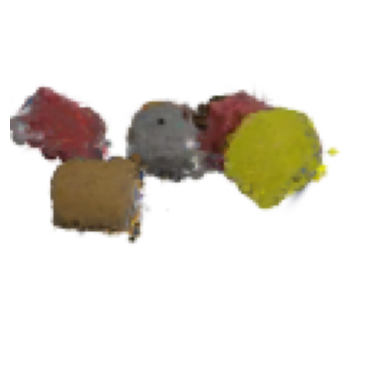

In [212]:
W, H = (128,128)
x = torch.randn((100, 3), device=device)

(render_colors,alphas,render_normals,surf_normals,_,_,info) = rasterization_2dgs(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    viewmats=w2cs,
    backgrounds=bg_color,
    Ks=Ks,
    width=W,
    height=H,
    packed=False,
    render_mode="RGB")

# render_colors, alphas, info = rasterization(means,quats,scales,opacities,colors,w2cs,Ks,W,H)

img = (render_colors[0]* 255.0).to(torch.uint8)
img = img.cpu().detach().numpy()

plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# from renderer import *

# img = render(means, quats, scales, opacities, colors, Ks, w2c)
# plt.imshow(img.cpu().numpy())
# plt.axis('off')
# plt.show()